## Diffusion models

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

### Kullback-Leibner Divergence

$$
    KL(q(x) || p(x)) = \mathbb{E}_{x\sim q(x)}[\log q(x) - \log p(x)]
$$

KL-divergence from scratch:  177.1358642578125
KL-divergence using pytorch: 177.1358642578125


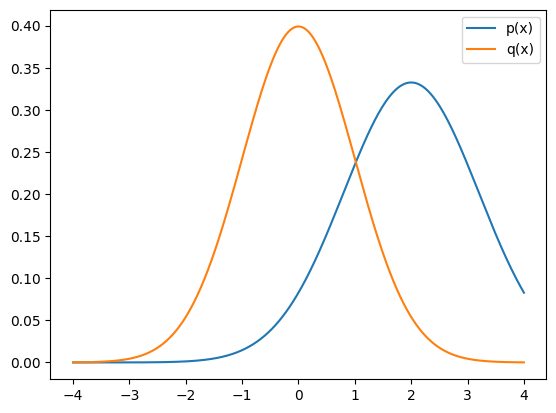

In [2]:
# general formula for a univariate Gaussian
def gaussian(x, mu, sigma):
    return 1/(sigma * (2*torch.pi)**0.5) * torch.exp(-.5 * (x-mu)**2 / sigma**2)

# define a linear range of values between -4 and 4 
x = torch.linspace(-4, 4, 1000)

# define two Gaussians with different parameters
p = gaussian(x, 2, 1.2)
q = gaussian(x, 0, 1)

plt.plot(x, p, label='p(x)')
plt.plot(x, q, label='q(x)')
plt.legend()

# kl(q || p) = sum q(x) (log q(x) - log p(x))
kl = torch.sum(q * (torch.log(q) - torch.log(p)))

# Built-in pytorch function: input is p(x) in log-space and target is q(x)
kl_torch = F.kl_div(torch.log(p), q, reduction='sum')

print(f"KL-divergence from scratch:  {kl}")
print(f"KL-divergence using pytorch: {kl_torch}")

### Simple Gaussian Mixture Model

Given 
$$
    \textbf{x}_0 \sim p_0(\textbf{x}) = \pi_1 \mathcal{N}(\textbf{x} | \mu_1, \sigma_1^2) + \pi_2 \mathcal{N}(\textbf{x} | \mu_2, \sigma_2^2)
$$
we know that
$$
    \textbf{x}_t = \sqrt{\alpha_t} \textbf{x}_{t-1} + \sqrt{(1-\alpha_t) \mathbf{\epsilon}}, \qquad \text{where } \mathbf{\epsilon} \sim \mathcal{N}(0, \textbf{I})
$$
For $t = 1, 2, \dots, T$, we can calculate the probability distribution of $\mathbf{x}_t$:
\begin{align*}
    p_t(\mathbf{x}) &= \pi_1 \mathcal{N}(\textbf{x} | \sqrt{\alpha_t} \mu_{1, t-1}, \alpha_t \sigma_{1, t-1}^2 + (1-\alpha_t))\\
    &+ \pi_2 \mathcal{N}(\textbf{x} | \sqrt{\alpha_t} \mu_{2, t-1}, \alpha_t \sigma_{2, t-1}^2 + (1-\alpha_t))
\end{align*}
gaussian = lambda x, mu, sigma: 1/(sigma * (2*torch.pi)**0.5) * torch.exp(-.5 * (x-mu)**2 / sigma**2)

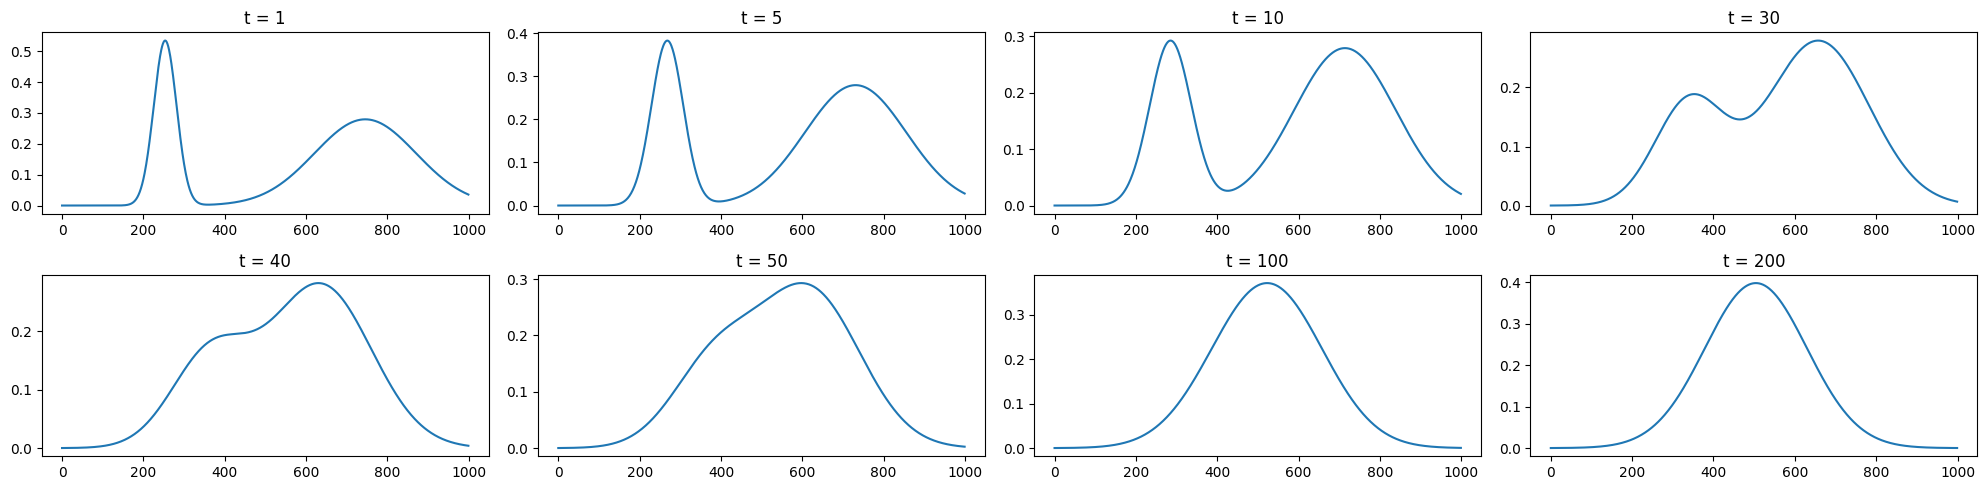

In [3]:
x = torch.linspace(-4, 4, 1000)

pi_1 = 0.3
pi_2 = 0.7

mu_1 = -2
mu_2 = 2

sigma_1 = 0.2
sigma_2 = 1

alpha_t = 0.97

ts = [1, 5, 10, 30, 40, 50, 100, 200]

fig, axes = plt.subplots(2, 4, figsize=(20, 5))
axes = axes.flatten()

for t, ax in zip(ts, axes): 

    p_t = pi_1 * gaussian(x, (alpha_t**0.5)**t * mu_1, alpha_t**t * sigma_1 + (1 - alpha_t**t)) \
        + pi_2 * gaussian(x, (alpha_t**0.5)**t * mu_2, alpha_t**t * sigma_2 + (1 - alpha_t**t))

    ax.plot(p_t)
    ax.set_title(f"t = {t}")

plt.tight_layout()
plt.show()

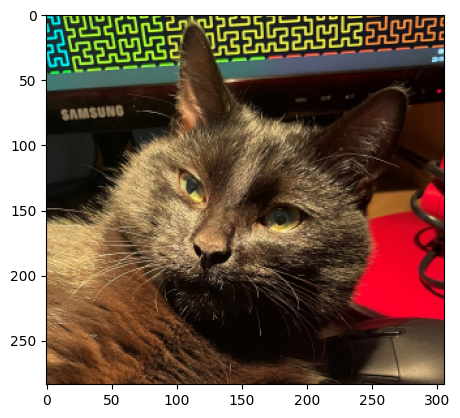

In [4]:
from PIL import Image

img = Image.open('../datasets/kat.png')
img.load()
img = torch.tensor(np.asarray(img, dtype='int32'))

plt.imshow(img, cmap="gray")

In [90]:
img.shape

torch.Size([284, 306, 4])

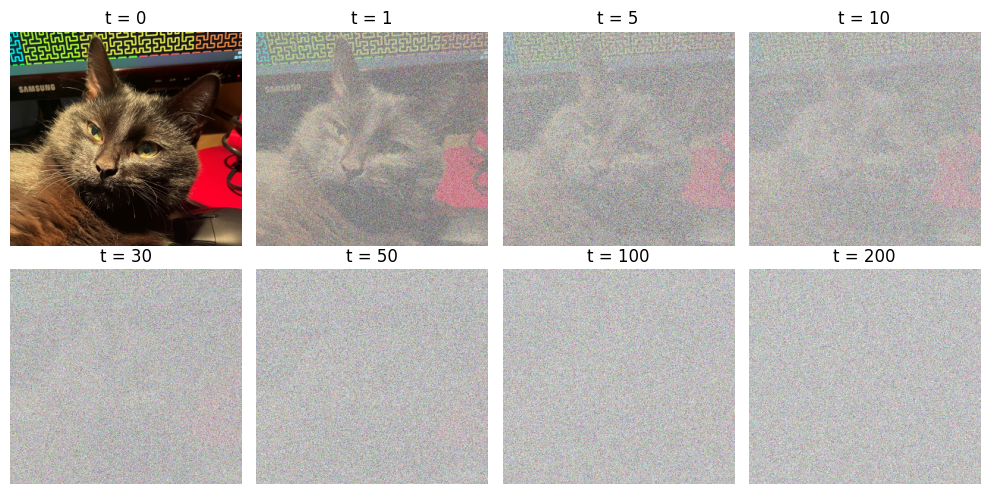

In [26]:
ts = [0, 1, 5, 10, 30, 50, 100, 200]

fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.flatten()

for t, ax in zip(ts, axes): 
    # forward diffusion
    perturbed_img = (alpha_t**t)**.5 * (img/255) + (1 - alpha_t**t)**.5 * np.random.randn(*img.shape)
    # normalize between (0, 1)
    perturbed_img = (perturbed_img + perturbed_img.min().abs()) / (perturbed_img + perturbed_img.min().abs()).max()
    ax.imshow(perturbed_img, cmap="gray")
    ax.axis('off')
    ax.set_title(f"t = {t}")
    
plt.tight_layout()

In [69]:
import torchvision
import torchvision.transforms as transforms

# define preprocessing transformations to dataset
transform = transforms.Compose([
    # transforms.Resize(32),
    # transforms.Normalize((0.5,), (0.5,)),
    transforms.ToTensor(),
])

# load training set
train_set = torchvision.datasets.MNIST(root="../datasets", train=True, download=True, transform=transform)

# load test/validation set
test_val_set = torchvision.datasets.MNIST(root="../datasets", train=False, download=True, transform=transform)

# split into separate test and validation sets
X_test_val, y_test_val = zip(*test_val_set)
X_test_val = torch.stack(X_test_val)
y_test_val = torch.tensor(y_test_val)

test_idx, val_idx = torch.utils.data.random_split(y_test_val, [5000, 5000])

X_test = X_test_val[test_idx.indices]
y_test = y_test_val[test_idx.indices]

X_val = X_test_val[val_idx.indices]
y_val = y_test_val[val_idx.indices]

(train_set.data.shape, train_set.targets.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([5000, 1, 28, 28]),
 torch.Size([5000]),
 torch.Size([5000, 1, 28, 28]),
 torch.Size([5000]))

In [70]:
import math

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings
    
spe = SinusoidalPositionEmbeddings(10)
spe(torch.randn(32)).shape

torch.Size([32, 10])

In [71]:
class LinearUnsqeezed(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(LinearUnsqeezed, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # X shape: (batch_size, input_dim)
        # output shape: (batch_size, output_dim, 1, 1)
        return self.linear(X)[..., None, None]

In [202]:
class Unet(nn.Module):
    def __init__(self, channels: list[int], embed_dim: int):
        super(Unet, self).__init__()
        
        self.embed = SinusoidalPositionEmbeddings(embed_dim)
        
        # Encoder
        # first encoder block is different from the others
        encoder = [
            nn.ModuleList([
                nn.Conv2d(
                    in_channels=1, 
                    out_channels=channels[0], 
                    kernel_size=3, stride=1, bias=False),
                LinearUnsqeezed(embed_dim, channels[0]),
                nn.GroupNorm(num_groups=4, num_channels=channels[0])
            ])
        ]
        # each block convolves over input, adds linearly mapped gaussian time step feature, and performs group normalization 
        for channel_in, channel_out in zip(channels, channels[1:]):
            group = nn.ModuleList([
                nn.Conv2d(
                    in_channels=channel_in, 
                    out_channels=channel_out, 
                    kernel_size=3, stride=2, 
                    bias=False),
                
                LinearUnsqeezed(input_dim=embed_dim, 
                                output_dim=channel_out),
                
                nn.GroupNorm(num_groups = 32, num_channels=channel_out)
            ])
            encoder.append(group)
        self.encoder = nn.ModuleList(encoder)
        
        # Decoder
        decoder = []
        # last transposed conv layer differs from the rest
        self.last_tconv2d = nn.ConvTranspose2d(
            in_channels=channels[0] + channels[0], 
            out_channels=1, 
            kernel_size=3, stride=1)
        
        for i, (channel_in, channel_out) in enumerate(zip(reversed(channels), reversed(channels[:-1]))):
            
            group = nn.ModuleList([
                nn.ConvTranspose2d(
                    in_channels=channel_in + channel_in if i != 0 else channel_in, 
                    out_channels=channel_out, 
                    kernel_size=3, stride=2, 
                    bias=False,
                    output_padding=1 if i != 0 else 0
                ),
                
                LinearUnsqeezed(input_dim=embed_dim, 
                                output_dim=channel_out),
                
                nn.GroupNorm(num_groups = 32, num_channels=channel_out)
            ])
            decoder.append(group)
        self.decoder = nn.ModuleList(decoder)
        
        # self.act = nn.ReLU()
        # Swish-1 activation function
        self.act = lambda x: x * torch.sigmoid(x)
    
    def forward(self, X: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        
        time_embedding = self.embed(t)
        
        skip_connections = []
        
        # encoder
        for conv, linear, batch_norm in self.encoder:
            X = conv(X)
            X += linear(time_embedding)
            X = batch_norm(X)
            X = self.act(X)
            skip_connections.append(X.clone())
        
        # decoder (with residual concatenations)
        for i, (H, (conv, linear, batch_norm)) in enumerate(zip(reversed(skip_connections), self.decoder)):
            # no concat if i == 0 because that's just cat([X, X], dim=1)
            X = conv(X if i == 0 else torch.cat([X, H], dim=1))
            X += linear(time_embedding)
            X = X if batch_norm is None else batch_norm(X)
            X = self.act(X)
        
        X = self.last_tconv2d(torch.cat([X, skip_connections[0]], dim=1))
        
        return X
    
unet = Unet([32, 64, 128, 256], 256)

unet(torch.randn(32, 1, 28, 28), torch.randn(32, )).shape


torch.Size([32, 1, 28, 28])

In [203]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

In [204]:
timesteps = 300

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

def loss_fn(model: nn.Module, X: torch.Tensor) -> torch.Tensor:
    
    batch_size = X.shape[0]
    random_t = torch.randint(1, timesteps, size=(batch_size,)).to(X.device)
    # time_steps_range = torch.arange(timesteps, device=X.device)
    noise = torch.randn_like(X)
    
    indexed_alphas = alphas_cumprod.to(X.device).take(random_t)
    
    perturbed_X = (indexed_alphas**0.5)[..., None, None, None] * X + ((1 - indexed_alphas)**0.5)[..., None, None, None] * noise
        
    pred_noise = model(perturbed_X, random_t)
    
    return F.mse_loss(pred_noise, noise)

In [205]:
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 1e-4
EMBED_DIM = 256
CHANNELS = [32, 64, 128, 256]

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [206]:
from torch.utils.data import DataLoader

data_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

model = Unet(
    channels=CHANNELS,
    embed_dim=EMBED_DIM
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

training_loss = []

Epoch: 0	Training loss: 0.3730
Epoch: 1	Training loss: 0.1494
Epoch: 2	Training loss: 0.1043
Epoch: 3	Training loss: 0.0833
Epoch: 4	Training loss: 0.0722
Epoch: 5	Training loss: 0.0661
Epoch: 6	Training loss: 0.0610
Epoch: 7	Training loss: 0.0583
Epoch: 8	Training loss: 0.0551
Epoch: 9	Training loss: 0.0526
Epoch: 10	Training loss: 0.0511
Epoch: 11	Training loss: 0.0495
Epoch: 12	Training loss: 0.0481
Epoch: 13	Training loss: 0.0474
Epoch: 14	Training loss: 0.0462
Epoch: 15	Training loss: 0.0450
Epoch: 16	Training loss: 0.0443
Epoch: 17	Training loss: 0.0436
Epoch: 18	Training loss: 0.0427
Epoch: 19	Training loss: 0.0423
Epoch: 20	Training loss: 0.0422
Epoch: 21	Training loss: 0.0418
Epoch: 22	Training loss: 0.0412
Epoch: 23	Training loss: 0.0406
Epoch: 24	Training loss: 0.0402
Epoch: 25	Training loss: 0.0402
Epoch: 26	Training loss: 0.0398
Epoch: 27	Training loss: 0.0396
Epoch: 28	Training loss: 0.0390
Epoch: 29	Training loss: 0.0390
Epoch: 30	Training loss: 0.0389
Epoch: 31	Training

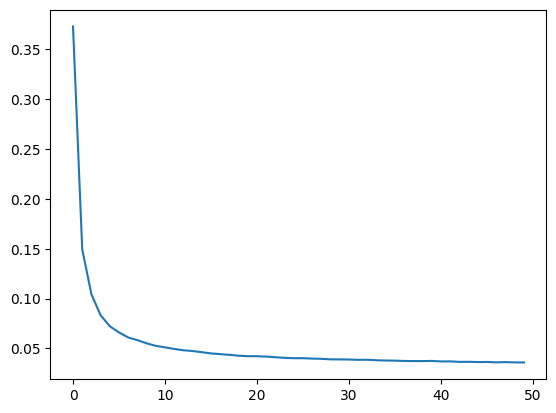

In [207]:
for epoch in range(EPOCHS):

    batch_loss, n_items = 0, 0
    for X, y in data_loader:
        X = X.to(DEVICE)
        
        loss = loss_fn(model, X)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss += loss.item() * X.shape[0]
        n_items += X.shape[0]
        
    training_loss.append(batch_loss / n_items)
    print(f"Epoch: {epoch}\tTraining loss: {training_loss[-1]:.4f}")
    
plt.plot(training_loss)

In [224]:
posterior_variance = betas * (1. - F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)) / (1. - alphas_cumprod)

noise = torch.randn(1, 1, 28, 28).to(DEVICE)

time = torch.tensor([timesteps]).to(DEVICE)

reverse_diffused_X = []

for t in reversed(range(timesteps)):
    
    reverse_diffused_X.append(noise.clone())
    
    z = torch.randn_like(noise) if t > 1 else torch.zeros_like(noise)
    
    recip_alphas_cumprod_sqrt = 1/alphas[t]**0.5
    
    one_minus_alphas_cumprod = 1-alphas_cumprod[t]
    
    pred_noise = model(noise, time)
    
    noise = recip_alphas_cumprod_sqrt * (noise - (1-alphas[t])/one_minus_alphas_cumprod**0.5 * pred_noise) + posterior_variance[t]**.5 * z
    # noise -= one_minus_alphas_cumprod/one_minus_alphas_cumprod**0.5 * pred_noise + posterior_variance[t]**.5 * z
    time -= 1

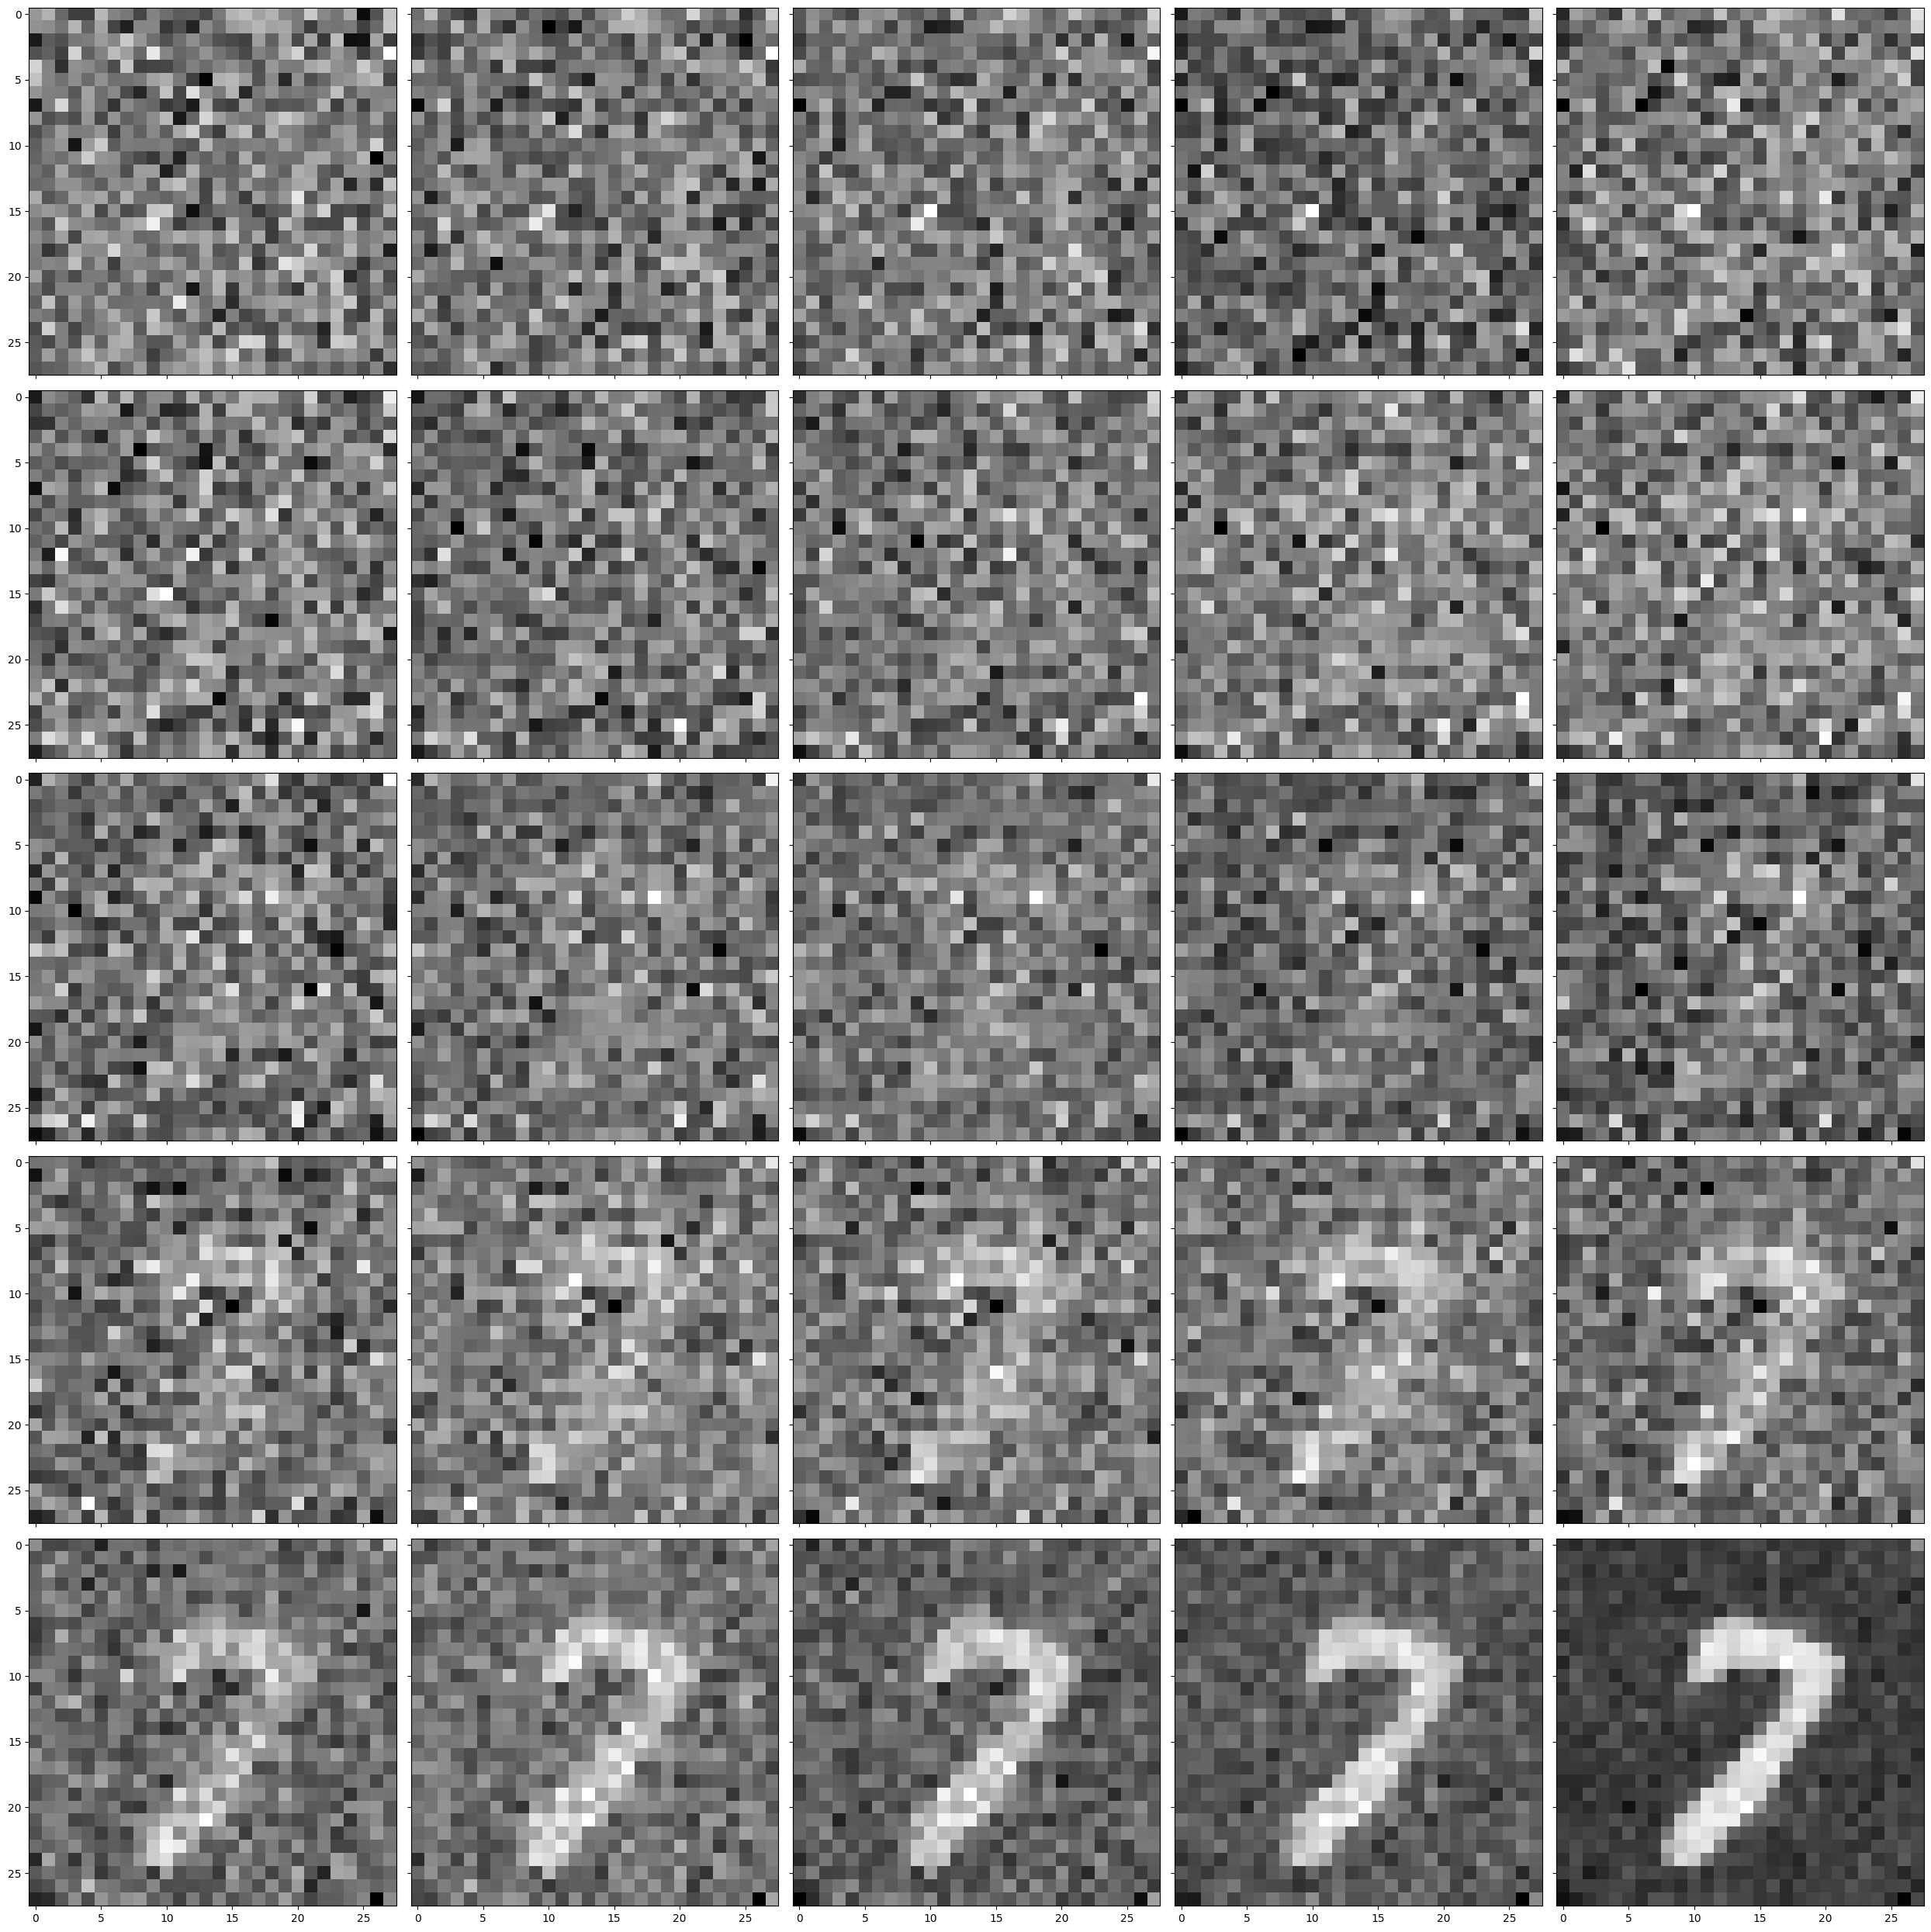

In [225]:
_, axes = plt.subplots(5, 5, figsize=(25, 25), sharex=True, sharey=True)
axes = axes.flatten()

for ax, diff_x in zip(axes, reverse_diffused_X[::timesteps//25]):
    ax.imshow(diff_x[0].cpu().detach().squeeze().unsqueeze(-1).numpy(), cmap='gray')

plt.tight_layout()

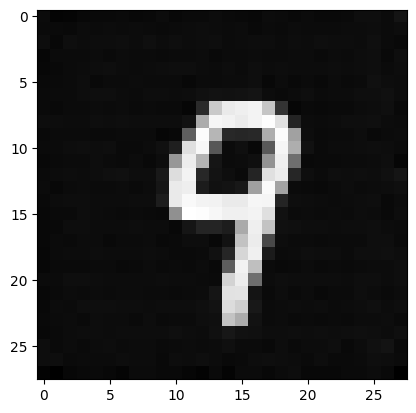

In [182]:
plt.imshow(reverse_diffused_X[-1][0].cpu().detach().squeeze().unsqueeze(-1).numpy(), cmap='gray')

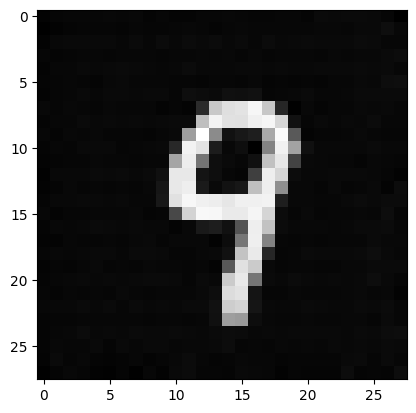

In [179]:
plt.imshow(reverse_diffused_X[-1][0].cpu().detach().squeeze().unsqueeze(-1).numpy(), cmap='gray')